# Advanced extension patterns in `sktime`

### Overview of this notebook

* using the advanced extension templates

    * example: forecaster with update and proba functionality
    * a closer look at tags, internal data formats
    * hierarchical data, automated vectorization
    * example: min-max scaler, but across multiple series
    * composite estimators
    * example: MA-of-transformed-data


* automated testing

    * using `check_estimator` as part of a test suite
    * using `sktime` test classes

In [1]:
import warnings

warnings.filterwarnings('ignore')

### `sktime` tags explained

all estimators have tags.

three types of tags:

* capability tags, e.g., "has `predict_proba`"
* property and type tags, e.g., "is a tree-based method", or "outputs series"
* behavioural tags, e.g., "instruction: convert to `numpy` for inner `_fit` method"


Tag related methods, via `BaseObject`:
* `get_tags`, `get_tag` - retrieve tag values
* `set_tags`, `clone_tags` - set tags, *developer use only* for implementing estimators

**Forecaster tags:**

Capability tags:
* `scitype:y`: which y are fine? univariate/multivariate/both
* `handles-missing-data`: can the estimator handle missing data? boolean, True or False
* `capability:pred_int`: does forecaster implement proba forecasts? boolean, True or False.

Property and type tags:
* `ignores-exogeneous-X`: does the estimator ignore the exogeneous X? boolean, True or False
* `requires-fh-in-fit`: is the forecasting horizon already required in fit? boolean, True or False.  
* `X-y-must-have-same-index`: can the estimator handle different X/y index? boolean, True or False.

Behavioural tags:
* `y_inner_mtype`: which types do _fit, _predict, assume for y? e.g. pd.Series
* `X_inner_mtype`: which types do _fit, _predict, assume for X? e.g. pd.DataFrame
* `enforce_index_type`: index type that needs to be enforced in X/y. None if index type is not enforced. 

**Transformer tags:**

Capability tags:
* `capability:inverse_transform`: can the transformer inverse transform? boolean, True or False
* `univariate-only`: can the transformer handle multivariate X? boolean, True or False
* `capability:unequal_length`: can the transformer handle unequal length time series (if passed Panel)? boolean, True or False
* `capability:unequal_length:removes`: is transform result always guaranteed to be equal length (and series)? not relevant for transformers that return Primitives in transform-output. boolean, True or False
* `handles-missing-data`: can estimator handle missing data? boolean, True or False
* `capability:missing_values:removes`: is transform result always guaranteed to contain no missing values? boolean, True or False

Property and type tags:
* `scitype:transform-input`: what is the scitype of X: Series, or Panel
* `scitype:transform-output`: what scitype is returned: Primitives, Series, Panel
* `scitype:transform-labels`: what is the scitype of y: None (not needed), Primitives, Series, Panel
* `scitype:instancewise`: is this an instance-wise transform? boolean, True or False  
    for example the [LogTransformer](https://github.com/alan-turing-institute/sktime/blob/4bf649b9a55861f8e7f61f017384d3e035a7d689/sktime/transformations/series/boxcox.py#L211) is applied on each time point individually.
* `requires_y`: does y need to be passed in fit? boolean, True or False
* `X-y-must-have-same-index`: can estimator handle different X/y index? boolean, True or False
* `transform-returns-same-time-index`: does transform return have the same time index as input X boolean, True or False

Behavioural tags:
* `X_inner_mtype`: which mtypes do _fit/_predict support for X? pd.DataFrame
* `y_inner_mtype`: which mtypes do _fit/_predict support for y? None if y is not used
* `enforce_index_type`: index type that needs to be enforced in X/y. None if no idex type is enforced
* `fit_is_empty`: is fit empty and can be skipped? Yes = True boolean, True or False
* `skip-inverse-transform`: is inverse-transform skipped when called? boolean, True or False

## Sktime scitypes and mtypes

Sktime distinguishes between time different time series data containers in 2 levels:
* **scitypes:** Short for scientific types. These are collections of multiple ways to represent the same information.
* **mtypes:** Short for machine types. These are specific, machine-readable representations of a scitype. Each scitype will typically have multiple mtypes.

The currently supported scitypes are:
* **Series:** uni- or multivariate time series
* **Panel:** panel of uni- or multivariate time series
* **Hierarchical:** hierarchical panel of time series with 3 or more levels
* **Alignment:** series or sequence alignment
* **Table:** data table with primitive column types
* **Proba:** probability distribution or distribution statistics, return types

For example the Panel scitype can be represented by the following mtypes:
* **nested_univ:**`pd.DataFrame` with one column per variable, pd.Series in cells
* **numpy3D:**3D `np.array` of format (n_instances, n_columns, n_timepoints)
* **pd-multiindex:**`pd.DataFrame` with multi-index (instances, timepoints)
* **pd-wide**:`pd.DataFrame` in wide format, cols = (instance * timepoints)
* **pd-long:**`pd.DataFrame` in long format, cols = (index, time_index, column)
* **df-list:**`list` of `pd.DataFrame`

You can convert a panel from one mtype to the other using the [convert](https://www.sktime.org/en/latest/api_reference/auto_generated/sktime.datatypes.convert.html) function.


In [28]:
from sktime.datatypes import convert
from sktime.datatypes import get_examples

print("nested_univ")
example_panel = get_examples(mtype="nested_univ")[0]
display(example_panel)
print("")

print("numpy3D")
example_panel = convert(obj=example_panel ,from_type="nested_univ", to_type="numpy3D")
display(example_panel)
print("")

print("pd-multiindex")
example_panel = convert(obj=example_panel ,from_type="numpy3D", to_type="pd-multiindex")
display(example_panel)
print("")

print("nested_univ")
example_panel = convert(obj=example_panel ,from_type="pd-multiindex", to_type="nested_univ")
display(example_panel)
print("")

nested_univ


,var_0,var_1
0,0 1 1 2 2 3 dtype: int64,0 4 1 5 2 6 dtype: int64
1,0 1 1 2 2 3 dtype: int64,0 4 1 55 2 6 dtype: int64
2,0 1 1 2 2 3 dtype: int64,0 42 1 5 2 6 dtype: int64



numpy3D


array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 1,  2,  3],
        [ 4, 55,  6]],

       [[ 1,  2,  3],
        [42,  5,  6]]])


pd-multiindex


var_0  var_1
instances timepoints              
0         0               1      4
          1               2      5
          2               3      6
1         0               1      4
          1               2     55
          2               3      6
2         0               1     42
          1               2      5
          2               3      6


nested_univ


,var_0,var_1
instances,,
0,"0 1 1 2 2 3 Name: var_0, dtype: int64","0 4 1 5 2 6 Name: var_1, dtype: int64"
1,"0 1 1 2 2 3 Name: var_0, dtype: int64","0 4 1 55 2 6 Name: var_1, dtype: int64"
2,"0 1 1 2 2 3 Name: var_0, dtype: int64","0 42 1 5 2 6 Name: var_1, dtype: int64"


# Implementing a simple moving average forecasting algorithm

We will use the extention templates to implement a simple moving average forecasting algorithm (not to be 
confused with a moving average which is not that simple). In it's simplest form, to create your own sktime compatible algorithm you only need to implement `__init__` and the private methods `_fit` and `_predict`. For this we will use the simple extension template.

If you also want to use the testing framework, you should implement the `get_test_params` method.

**Forecaster tags:**
* `scitype:y`: which y are fine? univariate/multivariate/both

* `ignores-exogeneous-X`: does the estimator ignore the exogeneous X? boolean, True or False

* `handles-missing-data`: can the estimator handle missing data? boolean, True or False

* `y_inner_mtype`: which types do _fit, _predict, assume for y? e.g. pd.Series

* `X_inner_mtype`: which types do _fit, _predict, assume for X? e.g. pd.DataFrame

* `requires-fh-in-fit`: is the forecasting horizon already required in fit? boolean, True or False.  
   (for example the [DirectTimeSeriesRegressionForecaster](https://github.com/alan-turing-institute/sktime/blob/4bf649b9a55861f8e7f61f017384d3e035a7d689/sktime/forecasting/compose/_reduce.py#L828) needs fh to be passed during the fit mehtod because it fits a separate regression model for every step in the horizon)

* `X-y-must-have-same-index`: can the estimator handle different X/y index? boolean, True or False.

* `enforce_index_type`: index type that needs to be enforced in X/y. None if index type is not enforced. 

* `capability:pred_int`: does forecaster implement proba forecasts? boolean, True or False.



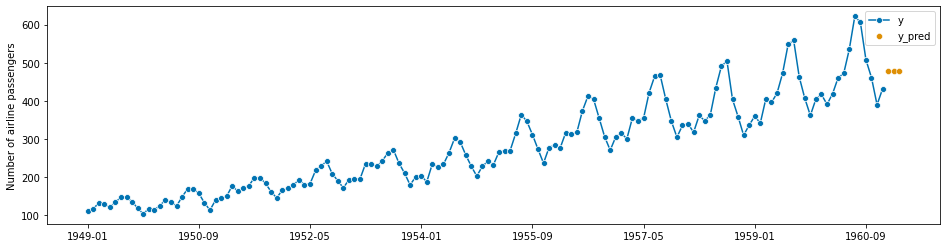

In [6]:
from pydata_sktime.simple_forecaster import SimpleMovingAverage

forecaster = SimpleMovingAverage(window_length=5)
forecaster.fit(y)
y_pred = forecaster.predict(fh=[1, 2, 3])
plot_series(y, y_pred, labels=["y", "y_pred"])
plt.show()

## What happens when we call fit?
Note: [make_mock_estimator]() is a testing/debugging utility function that returns an identical estimator as the one given in the inputs that logs all the methods that are called as well as their inputs

In [7]:
from pprint import pprint
from sktime.utils.estimators import make_mock_estimator

forecaster_class = make_mock_estimator(SimpleMovingAverage)
forecaster_instance = forecaster_class()
forecaster_instance.fit(y)

fit_log = forecaster_instance.log
unique_methods = list(dict.fromkeys([entry[0] for entry in fit_log]))
pprint([entry[0] for entry in fit_log])
print("")

for method in unique_methods:
    print(f"{method}:\n")
    help(getattr(SimpleMovingAverage, method))
    print("")

['fit',
 'reset',
 'get_params',
 '_check_fh',
 'get_tag',
 'get_tags',
 '_check_X_y',
 'get_tag',
 'get_tags',
 'get_tag',
 'get_tags',
 'get_tag',
 'get_tags',
 'get_tag',
 'get_tags',
 '_update_y_X',
 '_set_cutoff_from_y',
 '_fit']

fit:

Help on function fit in module sktime.forecasting.base._base:

fit(self, y, X=None, fh=None)
    Fit forecaster to training data.
    
    State change:
        Changes state to "fitted".
    
    Writes to self:
        Sets self._is_fitted flag to True.
        Writes self._y and self._X with `y` and `X`, respectively.
        Sets self.cutoff and self._cutoff to last index seen in `y`.
        Sets fitted model attributes ending in "_".
        Stores fh to self.fh if fh is passed.
    
    Parameters
    ----------
    y : time series in sktime compatible data container format
            Time series to which to fit the forecaster.
        y can be in one of the following formats:
        Series scitype: pd.Series, pd.DataFrame, or np.ndarray (

## What happens when we call predict?

In [8]:
from pprint import pprint
from sktime.utils.estimators import make_mock_estimator

forecaster_class = make_mock_estimator(SimpleMovingAverage)
forecaster_instance = forecaster_class()
forecaster_instance.fit(y)
forecaster_instance.predict(fh=[1, 2, 3])

predict_log = forecaster_instance.log[len(fit_log):]
unique_methods = list(dict.fromkeys([entry[0] for entry in predict_log]))
pprint([entry[0] for entry in predict_log])
print("")

for method in unique_methods:
    print(f"{method}:\n")
    help(getattr(SimpleMovingAverage, method))
    print("")

['predict',
 'check_is_fitted',
 '_check_fh',
 'get_tag',
 'get_tags',
 '_check_X',
 '_check_X_y',
 '_predict']

predict:

Help on function predict in module sktime.forecasting.base._base:

predict(self, fh=None, X=None)
    Forecast time series at future horizon.
    
    State required:
        Requires state to be "fitted".
    
    Accesses in self:
        Fitted model attributes ending in "_".
        self.cutoff, self._is_fitted
    
    Writes to self:
        Stores fh to self.fh if fh is passed and has not been passed previously.
    
    Parameters
    ----------
    fh : int, list, np.array or ForecastingHorizon, optional (default=None)
        The forecasting horizon encoding the time stamps to forecast at.
        if has not been passed in fit, must be passed, not optional
    X : time series in sktime compatible format, optional (default=None)
            Exogeneous time series to fit to
        Should be of same scitype (Series, Panel, or Hierarchical) as y in fit
     

# Testing Framework
*How do I ensure that my new estimator is good and compatible with the sktime API?*

sktime has a [check_estimator](https://www.sktime.org/en/latest/api_reference/auto_generated/sktime.utils.estimator_checks.check_estimator.html?highlight=make_mock_estimator#sktime.utils.estimator_checks.check_estimator) utility function that runs all the automated tests based on the type and tags of the estimator. You can use this in a notebook like below or as part of your own project's unit tests.

In [9]:
from sktime.utils.estimator_checks import check_estimator

MY_ESTIMATORS = [SimpleMovingAverage, MinMaxScaler]

for estimator_class in MY_ESTIMATORS:
    print(estimator_class)
    check_estimator(estimator_class, return_exceptions=False)
    print("")

<class 'pydata_sktime.simple_forecaster._forecaster.SimpleMovingAverage'>
All tests PASSED!

<class 'pydata_sktime.simple_transformer._transformer.MinMaxScaler'>
All tests PASSED!



## What if the estimator has a bug?

We've made a buggy version of each estimator with some common mistakes:
1. SimpleMovingAverage will have a wrong capability tag
2. MinMaxScale's _transform will change the state of the instance

In [10]:
from pydata_sktime.buggy_forecaster import SimpleMovingAverage
from pydata_sktime.buggy_transformer import  MinMaxScaler

MY_ESTIMATORS = [SimpleMovingAverage, MinMaxScaler]

for estimator_class in MY_ESTIMATORS:
    print(estimator_class)
    check_estimator(estimator_class, return_exceptions=True)
    print("")

<class 'pydata_sktime.buggy_forecaster._forecaster.SimpleMovingAverage'>
FAILED: test_fit_idempotent[SimpleMovingAverage-0-ForecasterFitPredictUnivariateWithX]
FAILED: test_fit_idempotent[SimpleMovingAverage-1-ForecasterFitPredictUnivariateWithX]
FAILED: test_fit_idempotent[SimpleMovingAverage-2-ForecasterFitPredictUnivariateWithX]
FAILED: test_methods_do_not_change_state[SimpleMovingAverage-0-ForecasterFitPredictUnivariateWithX]
FAILED: test_methods_do_not_change_state[SimpleMovingAverage-1-ForecasterFitPredictUnivariateWithX]
FAILED: test_methods_do_not_change_state[SimpleMovingAverage-2-ForecasterFitPredictUnivariateWithX]
FAILED: test_methods_have_no_side_effects[SimpleMovingAverage-0-ForecasterFitPredictUnivariateWithX]
FAILED: test_methods_have_no_side_effects[SimpleMovingAverage-1-ForecasterFitPredictUnivariateWithX]
FAILED: test_methods_have_no_side_effects[SimpleMovingAverage-2-ForecasterFitPredictUnivariateWithX]
FAILED: test_persistence_via_pickle[SimpleMovingAverage-0-Forec